In [87]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

import random

from codebase import utils as ut
from codebase import models

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Exercise 1

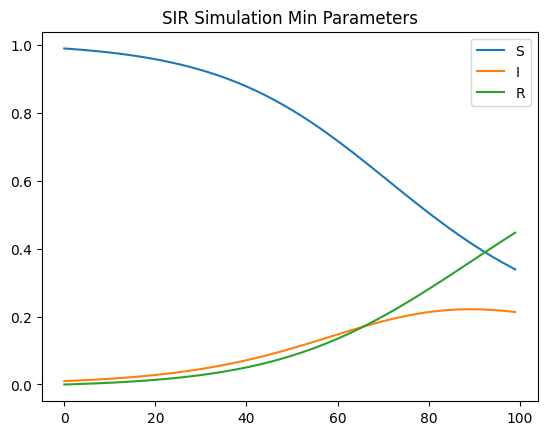

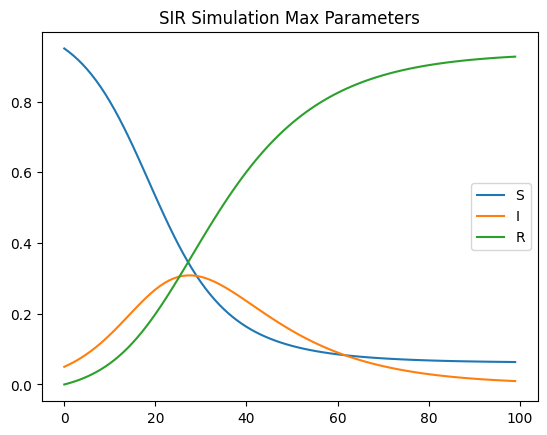

In [72]:
lam_min=0.095
lam_max=0.2
mu_min=0.04
mu_max=0.07
I0_min=0.01
I0_max=0.05

ut.plot_sir_single(lam_min, mu_min, I0_min, title='SIR Simulation Min Parameters')
ut.plot_sir_single(lam_max, mu_max, I0_max, title='SIR Simulation Max Parameters')

I tried to shift the 'peak' of the Infektions to the end with the minimal parameters and to the beginning with the max parameters 

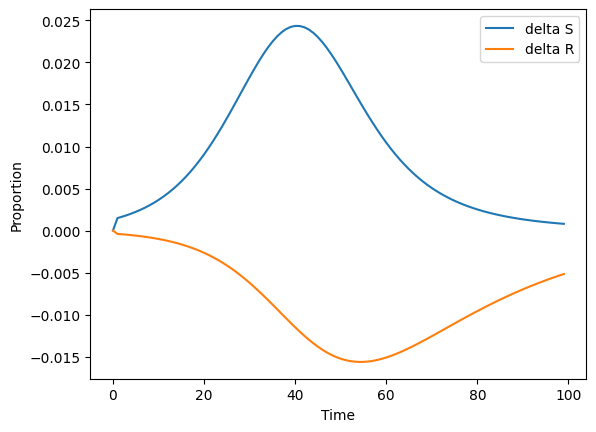

In [73]:
# parameters 
lam = 0.15
mu = 0.04
I_0 = 0.01
T = 100

# simulate
X = ut.simulate_sir_simple(lam, mu, I_0, T)

plt.plot(X[:, 0], label='delta S')
plt.plot(X[:, 1], label='delta R')
plt.xlabel('Time')
plt.ylabel('Proportion')
plt.legend()
plt.show()

In [95]:
# define the prior distribution for the simulation parameters
def prior_distribution(num_samples = 1):
    lam = np.random.uniform(0.1, 0.2, num_samples)
    mu = np.random.uniform(0.01, 0.05, num_samples)
    I_0 = np.random.uniform(0.005, 0.02, num_samples)
    return np.array(list(zip(lam, mu, I_0)))

### 1.3

In [ ]:
from codebase import models

%load_ext autoreload
%autoreload 2

In [99]:
# def train_feedforward(model, simulation, priors, epochs, lr, days):
#     criterion = nn.MSELoss()
#     optimizer = optim.Adam(model.parameters(), lr=lr)
#     losses = []

#     for epoch in range(epochs):
#         sample = priors()
#         # create tensor
#         X = torch.tensor(simulation(*sample, days), dtype=torch.float32)
#         print('test1', X.shape)
#         # duplicate samples 
#         samples = [sample for _ in range(days)]
#         samples = torch.tensor(samples, dtype=torch.float32).to(device)
#         # pass through model
#         print('samples', samples.shape)
#         print(samples)
#         output = model(X)
#         # calculate loss
#         loss = criterion(output, samples)
#         # training
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         losses.append(loss.item())
#         #print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')
#     return losses

In [108]:
# von Anton

def train_feedforward(model, simulation, priors, epochs, lr, days, training_set_size):
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # train the model
    for epoch in range(epochs):
        samples = priors(training_set_size)
        X = np.array([simulation(*sample, days) for sample in samples])
        print('X', X.shape)
        X = torch.tensor(X, dtype=torch.float32).to(device)
        X = X.view(X.size(0), -1)  # Flatten the time and feature dimensions
        print('X2', X.shape)
        samples = torch.tensor(samples, dtype=torch.float32).to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward pass
        y_pred = model(X)
        print('y_pred', y_pred.shape)
        # calculate the loss
        loss = loss_fn(y_pred, samples)
        # backward pass
        loss.backward()
        # optimize
        optimizer.step()
        # print the loss
        if epoch % days == 0:
            print(f'Epoch {epoch}, Loss {loss.item()}')

In [85]:
sample = prior_distribution() 
ut.simulate_sir_simple(*sample, 10)

array([[ 0.        ,  0.        ],
       [ 0.00359117, -0.00118562],
       [ 0.00391538, -0.00129743],
       [ 0.00426534, -0.00141912],
       [ 0.00464241, -0.00155142],
       [ 0.00504789, -0.0016951 ],
       [ 0.00548294, -0.00185095],
       [ 0.00594862, -0.00201977],
       [ 0.00644576, -0.00220239],
       [ 0.00697496, -0.00239964]])

In [109]:
# test run of the simulation 
model = models.FeedForward(200, 64, 2, 3).to(device)
print(model)

train_feedforward(model, ut.simulate_sir_simple, prior_distribution, epochs=50, lr=0.001, days=100, training_set_size=11)

FeedForward(
  (network): Sequential(
    (0): Linear(in_features=200, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=3, bias=True)
  )
)
X (11, 100, 2)
X2 torch.Size([11, 200])
y_pred torch.Size([11, 3])
Epoch 0, Loss 0.012019648216664791
X (11, 100, 2)
X2 torch.Size([11, 200])
y_pred torch.Size([11, 3])
X (11, 100, 2)
X2 torch.Size([11, 200])
y_pred torch.Size([11, 3])
X (11, 100, 2)
X2 torch.Size([11, 200])
y_pred torch.Size([11, 3])
X (11, 100, 2)
X2 torch.Size([11, 200])
y_pred torch.Size([11, 3])
X (11, 100, 2)
X2 torch.Size([11, 200])
y_pred torch.Size([11, 3])
X (11, 100, 2)
X2 torch.Size([11, 200])
y_pred torch.Size([11, 3])
X (11, 100, 2)
X2 torch.Size([11, 200])
y_pred torch.Size([11, 3])
X (11, 100, 2)
X2 torch.Size([11, 200])
y_pred torch.Size([11, 3])
X (11, 100, 2)
X2 torch.Size([11, 200])
y_pred torch.Size([11, 3])
X (11, 100, 2)
X2 torch.Size([11, 200])

In [64]:
# define function to evaluate the model 
def mse_evaluation(model, X, parameters, days):
    duplicates = [parameters for _ in range(days)]
    duplicates = torch.tensor(duplicates, dtype=torch.float32).to(device)
    X = torch.tensor(X, dtype=torch.float32).to(device)
    output = model(X)

    MSE = nn.MSELoss()(output, duplicates).item()

    return MSE


In [ ]:
# test the evaluation function
lam = 0.15
mu = 0.04
I_0 = 0.01
parameters = np.array([lam, mu, I_0])
X_test = ut.simulate_sir_simple(*parameters, 100) 

# evaluate the model
mse_evaluation(model, X_test, parameters, 100)


0.0006187797989696264

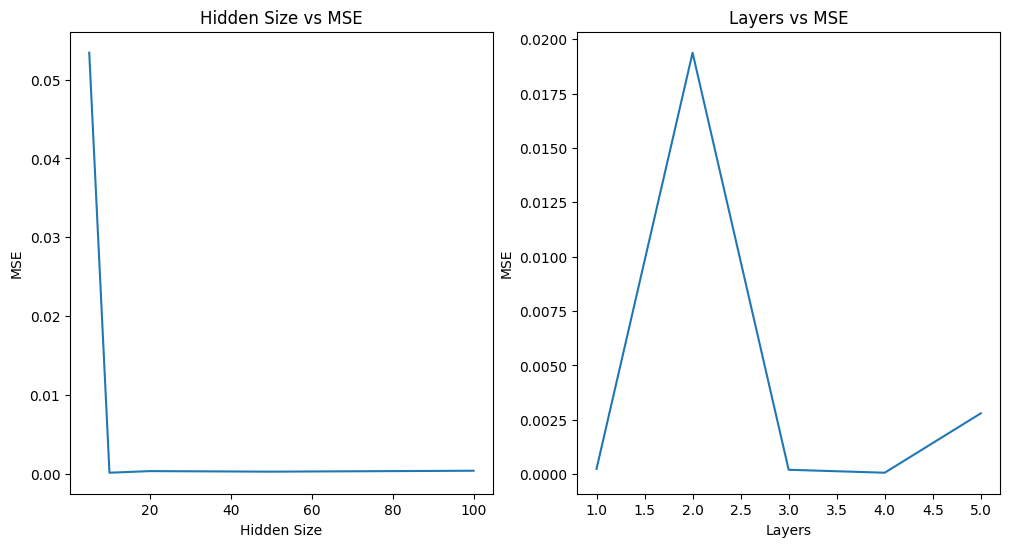

In [101]:
# define model test set 
lam = 0.15
mu = 0.04
I_0 = 0.01
parameters = np.array([lam, mu, I_0])
X_test = ut.simulate_sir_simple(*parameters, 100) 

# define hyperparameters 
hidden_sizes = [5, 10, 20, 50, 100]
layers = [1, 2, 3, 4, 5]
default_layers = 2
default_hidden_size = 10
lr = 0.001
epochs = 100
days = 100


# plot different model hyperparameters for the feed forward model

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
hidden_size_mse = []
layer_mse = []
for hidden_size in hidden_sizes:
    model = models.FeedForward(2, hidden_size, default_layers, 3).to(device)
    losses = train_feedforward(model, models.simulate_sir_simple, prior_distribution, epochs, lr, days)
    hidden_size_mse.append(mse_evaluation(model, X_test, parameters, days))

for layer in layers:
    model = models.FeedForward(2, default_hidden_size, layer, 3).to(device)
    losses = train_feedforward(model, models.simulate_sir_simple, prior_distribution, epochs, lr, days)
    layer_mse.append(mse_evaluation(model, X_test, parameters, days))


ax[0].plot(hidden_sizes, hidden_size_mse)
ax[0].set_xlabel('Hidden Size')
ax[0].set_ylabel('MSE')
ax[0].set_title('Hidden Size vs MSE')
ax[1].plot(layers, layer_mse)
ax[1].set_xlabel('Layers')
ax[1].set_ylabel('MSE')
ax[1].set_title('Layers vs MSE')
plt.show()


